In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import datetime
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
flights = pd.read_csv('airline2008.csv')
airports = pd.read_csv('airports.csv')
carriers = pd.read_csv('carriers.csv')
print(flights.shape)

(7009728, 29)


In [3]:
df = flights.sample(frac=0.05)
print(df.shape)
df.head()

(350486, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
5140508,2008,9,12,5,931.0,930,1051.0,1051,EV,4670,...,10.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5010301,2008,9,11,4,755.0,800,838.0,844,OO,6552,...,7.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5163542,2008,9,5,5,1917.0,1922,2120.0,2110,FL,50,...,14.0,21.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2898369,2008,5,14,3,1051.0,1045,1224.0,1215,AA,1463,...,6.0,23.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4253090,2008,8,8,5,1447.0,1440,1713.0,1710,WN,1428,...,9.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [4]:
#check to see how much our data set is empty and which features are most empty
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,CancellationCode,343592,1.966983
1,LateAircraftDelay,274152,21.779472
2,NASDelay,274152,21.779472
3,WeatherDelay,274152,21.779472
4,CarrierDelay,274152,21.779472
5,SecurityDelay,274152,21.779472
6,AirTime,7743,97.790782
7,ActualElapsedTime,7743,97.790782
8,ArrDelay,7743,97.790782
9,ArrTime,7606,97.829871


In [5]:
#lets remove features with lots of missing data or that won't be helpful
features_to_remove = ['FlightNum', 'TailNum', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted',
                     'LateAircraftDelay', 'NASDelay', 'WeatherDelay', 'CarrierDelay', 'SecurityDelay']
df = df.drop(features_to_remove, 1)

In [6]:
#remove the few remaining NaNs in the dataset
df = df.dropna()
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance
5140508,2008,9,12,5,931.0,930,1051.0,1051,EV,80.0,81.0,61.0,0.0,1.0,FAY,ATL,331
5010301,2008,9,11,4,755.0,800,838.0,844,OO,43.0,44.0,19.0,-6.0,-5.0,ORD,MKE,67
5163542,2008,9,5,5,1917.0,1922,2120.0,2110,FL,303.0,288.0,268.0,10.0,-5.0,ATL,LAX,1946
2898369,2008,5,14,3,1051.0,1045,1224.0,1215,AA,153.0,150.0,124.0,9.0,6.0,ORD,DEN,888
4253090,2008,8,8,5,1447.0,1440,1713.0,1710,WN,146.0,150.0,128.0,3.0,7.0,SEA,LAS,866


In [7]:
#rename 'DayofMonth' to 'Day' for the datetime format
df = df.rename(index=str, columns={'DayofMonth': 'Day'})

#convert year, month, day to datetime format in single feature and drop the orignal three
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.drop(['Year', 'Month', 'Day'], 1)
df.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,date
5140508,5,931.0,930,1051.0,1051,EV,80.0,81.0,61.0,0.0,1.0,FAY,ATL,331,2008-09-12
5010301,4,755.0,800,838.0,844,OO,43.0,44.0,19.0,-6.0,-5.0,ORD,MKE,67,2008-09-11
5163542,5,1917.0,1922,2120.0,2110,FL,303.0,288.0,268.0,10.0,-5.0,ATL,LAX,1946,2008-09-05
2898369,3,1051.0,1045,1224.0,1215,AA,153.0,150.0,124.0,9.0,6.0,ORD,DEN,888,2008-05-14
4253090,5,1447.0,1440,1713.0,1710,WN,146.0,150.0,128.0,3.0,7.0,SEA,LAS,866,2008-08-08


In [8]:
# Function that convert all the values to a 'HHMM' string
def format_hour(a):
    if pd.isnull(a):
        return np.nan
    else:
        if a == 2400: a = 0
        a = "{0:04d}".format(int(a))
        hour = datetime.time(int(a[0:2]), int(a[2:4]))
        return hour

In [9]:
#turn our 'HHMM' into a datetime format
df['CRSDepTime'] = df['CRSDepTime'].apply(format_hour)
df['DepTime'] = df['DepTime'].apply(format_hour)
df['CRSArrTime'] = df['CRSArrTime'].apply(format_hour)
df['ArrTime'] = df['ArrTime'].apply(format_hour)

df.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,date
5140508,5,09:31:00,09:30:00,10:51:00,10:51:00,EV,80.0,81.0,61.0,0.0,1.0,FAY,ATL,331,2008-09-12
5010301,4,07:55:00,08:00:00,08:38:00,08:44:00,OO,43.0,44.0,19.0,-6.0,-5.0,ORD,MKE,67,2008-09-11
5163542,5,19:17:00,19:22:00,21:20:00,21:10:00,FL,303.0,288.0,268.0,10.0,-5.0,ATL,LAX,1946,2008-09-05
2898369,3,10:51:00,10:45:00,12:24:00,12:15:00,AA,153.0,150.0,124.0,9.0,6.0,ORD,DEN,888,2008-05-14
4253090,5,14:47:00,14:40:00,17:13:00,17:10:00,WN,146.0,150.0,128.0,3.0,7.0,SEA,LAS,866,2008-08-08


In [10]:
#add feature that classifies a flight as late or not if it is delayed more than 30 minutes
df['dep_bool'] = np.where(df['DepDelay'] > 30, 1, 0)

#add feature that gives us average mph for the flight
df['average_mph'] = df['Distance'] / (df['AirTime'] / 60)

#add a feature compares the scheduled flight time with actual flight time
df['elapsed_difference'] = df['ActualElapsedTime'] - df['CRSElapsedTime']

#add a feature that computes how long the flight was on the ground for
df['taxi_time'] = df['ActualElapsedTime'] - df['AirTime']

df.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,date,dep_bool,average_mph,elapsed_difference,taxi_time
5140508,5,09:31:00,09:30:00,10:51:00,10:51:00,EV,80.0,81.0,61.0,0.0,1.0,FAY,ATL,331,2008-09-12,0,325.573770,-1.0,19.0
5010301,4,07:55:00,08:00:00,08:38:00,08:44:00,OO,43.0,44.0,19.0,-6.0,-5.0,ORD,MKE,67,2008-09-11,0,211.578947,-1.0,24.0
5163542,5,19:17:00,19:22:00,21:20:00,21:10:00,FL,303.0,288.0,268.0,10.0,-5.0,ATL,LAX,1946,2008-09-05,0,435.671642,15.0,35.0
2898369,3,10:51:00,10:45:00,12:24:00,12:15:00,AA,153.0,150.0,124.0,9.0,6.0,ORD,DEN,888,2008-05-14,0,429.677419,3.0,29.0
4253090,5,14:47:00,14:40:00,17:13:00,17:10:00,WN,146.0,150.0,128.0,3.0,7.0,SEA,LAS,866,2008-08-08,0,405.937500,-4.0,18.0


In [11]:
#create a dictionary for the carriers so we don't have to use the codes
carriers_dict = dict(zip(carriers['Code'], carriers['Description']))
df['UniqueCarrier'] = df['UniqueCarrier'].apply(lambda x: carriers_dict[x])

In [12]:
df.groupby('UniqueCarrier')['average_mph'].describe()

,count,mean,std,min,25%,50%,75%,max
UniqueCarrier,,,,,,,,
AirTran Airways Corporation,13090.0,408.409844,49.504149,178.144330,377.142857,410.909091,440.000000,6.891176e+02
Alaska Airlines Inc.,7390.0,418.574241,60.322771,97.894737,388.235294,424.067797,455.121951,6.063158e+02
Aloha Airlines Inc.,398.0,inf,NaN,166.666667,266.086957,315.483871,350.024131,inf
American Airlines Inc.,29335.0,431.754305,60.725182,119.516129,396.666667,437.910448,472.876712,6.206494e+02
American Eagle Airlines Inc.,23501.0,348.195929,74.134591,79.000000,300.000000,355.000000,399.807692,5.833043e+02
Atlantic Southeast Airlines,13773.0,368.185204,69.472122,93.714286,327.428571,378.888889,417.457627,8.784000e+02
Comair Inc.,9488.0,353.566468,198.211854,53.006135,308.571429,356.470588,399.259259,1.752000e+04
Continental Air Lines Inc.,14429.0,426.000941,68.863254,137.704918,395.885167,435.744681,470.400000,6.133758e+02
Delta Air Lines Inc.,22176.0,411.224926,66.324033,88.095238,373.179483,415.058824,451.150831,7.238095e+02


In [13]:
#planes can't fly over 800mph so lets drop those values
speed_df = df[df['average_mph'] < 800]

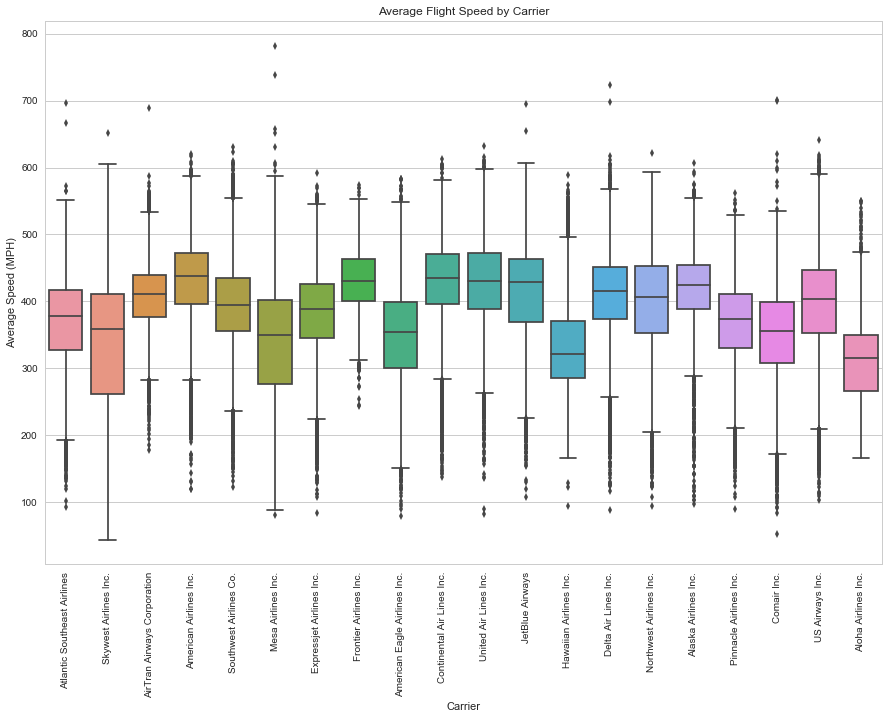

In [14]:
#boxplot of average flight speed by carrier
plt.figure(figsize=(15, 10))
sns.boxplot(x='UniqueCarrier', y='average_mph', data=speed_df)
plt.xticks(rotation='vertical')
plt.ylabel('Average Speed (MPH)')
plt.xlabel('Carrier')
plt.title('Average Flight Speed by Carrier')
plt.show()

In [15]:
delay_df = pd.DataFrame(df.groupby('UniqueCarrier')[['ArrDelay','DepDelay']].mean())
delay_df = delay_df.reset_index()
delay_df.head()

,UniqueCarrier,ArrDelay,DepDelay
0,AirTran Airways Corporation,9.056684,9.238579
1,Alaska Airlines Inc.,4.656428,6.550068
2,Aloha Airlines Inc.,-4.103015,-2.072864
3,American Airlines Inc.,12.525925,13.199864
4,American Eagle Airlines Inc.,9.454747,10.365687


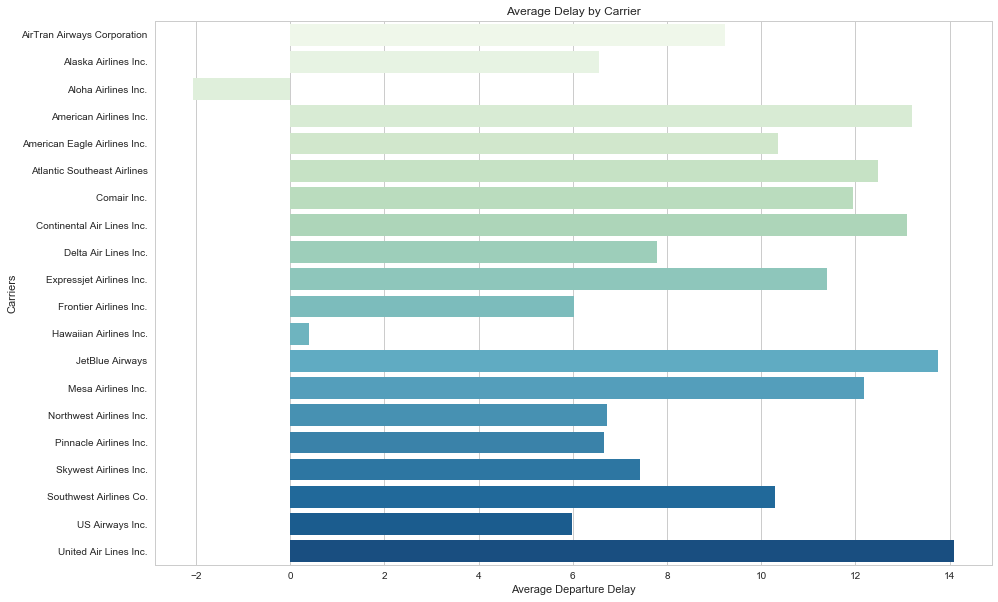

In [16]:
plt.figure(figsize=(15, 10))
sns.barplot(y='UniqueCarrier', x='DepDelay', data=delay_df, palette='GnBu')
plt.xlabel('Average Departure Delay')
plt.ylabel('Carriers')
plt.title('Average Delay by Carrier')
plt.show()

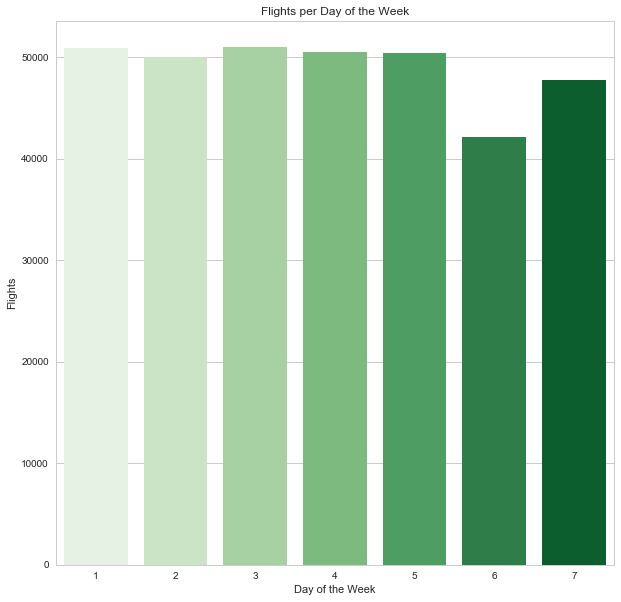

In [17]:
plt.figure(figsize=(10, 10))
sns.countplot(x='DayOfWeek', data=df, palette='Greens')
plt.xlabel('Day of the Week')
plt.ylabel('Flights')
plt.title('Flights per Day of the Week')

plt.show()

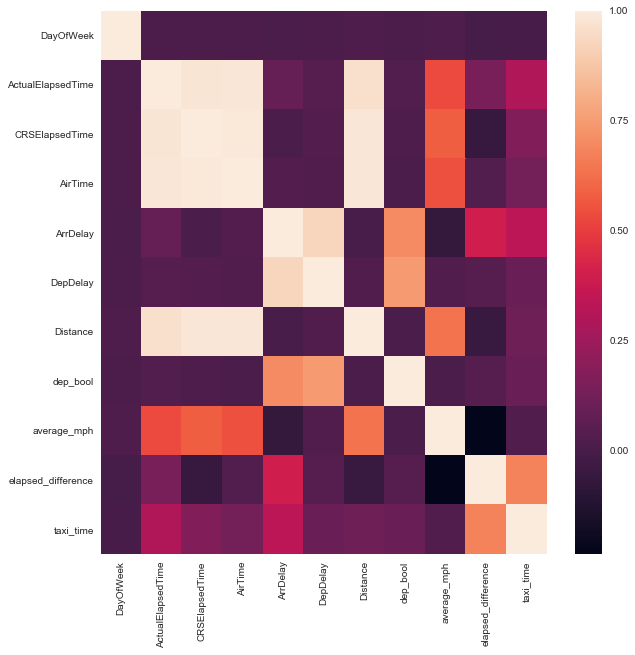

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr())
plt.show()

In [19]:
final_df = df.drop(['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'date', 'ArrDelay'], 1)
final_df.head()

,DayOfWeek,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Origin,Dest,Distance,dep_bool,average_mph,elapsed_difference,taxi_time
5140508,5,Atlantic Southeast Airlines,80.0,81.0,61.0,1.0,FAY,ATL,331,0,325.573770,-1.0,19.0
5010301,4,Skywest Airlines Inc.,43.0,44.0,19.0,-5.0,ORD,MKE,67,0,211.578947,-1.0,24.0
5163542,5,AirTran Airways Corporation,303.0,288.0,268.0,-5.0,ATL,LAX,1946,0,435.671642,15.0,35.0
2898369,3,American Airlines Inc.,153.0,150.0,124.0,6.0,ORD,DEN,888,0,429.677419,3.0,29.0
4253090,5,Southwest Airlines Co.,146.0,150.0,128.0,7.0,SEA,LAS,866,0,405.937500,-4.0,18.0


In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for columns in final_df.select_dtypes(object):
    final_df[columns] = le.fit_transform(final_df[columns])
    
final_df = final_df.replace([np.inf, -np.inf], np.nan)
final_df = final_df.dropna()
final_df.head()

,DayOfWeek,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Origin,Dest,Distance,dep_bool,average_mph,elapsed_difference,taxi_time
5140508,5,5,80.0,81.0,61.0,1.0,101,18,331,0,325.573770,-1.0,19.0
5010301,4,16,43.0,44.0,19.0,-5.0,210,187,67,0,211.578947,-1.0,24.0
5163542,5,0,303.0,288.0,268.0,-5.0,18,157,1946,0,435.671642,15.0,35.0
2898369,3,3,153.0,150.0,124.0,6.0,210,80,888,0,429.677419,3.0,29.0
4253090,5,17,146.0,150.0,128.0,7.0,256,155,866,0,405.937500,-4.0,18.0


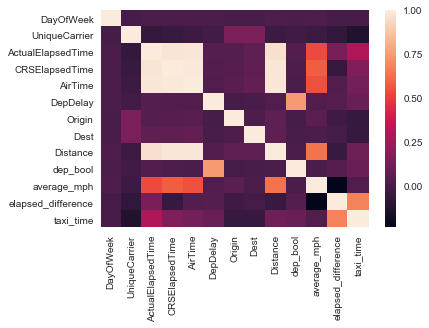

In [24]:
sns.heatmap(final_df.corr())

In [26]:
from sklearn import ensemble

X = final_df.drop(['DepDelay', 'dep_bool'], 1)
y = final_df.DepDelay

rfr = ensemble.RandomForestRegressor()
rfr.fit(X, y)
print(sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), X.columns), 
             reverse=True))

[(0.1939, 'average_mph'), (0.1015, 'elapsed_difference'), (0.0963, 'taxi_time'), (0.092, 'ActualElapsedTime'), (0.0882, 'AirTime'), (0.0878, 'Origin'), (0.0829, 'CRSElapsedTime'), (0.078, 'Dest'), (0.0743, 'DayOfWeek'), (0.0661, 'Distance'), (0.039, 'UniqueCarrier')]


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [29]:
from sklearn.model_selection import cross_val_score

rfr1 = ensemble.RandomForestRegressor()
rfr1.fit(X_train, y_train)
y_pred = rfr1.predict(X_test)
print('RFR Training Score: ', rfr1.score(X_train, y_train))
print('RFR Test Score: ', rfr1.score(X_test, y_test))
print('RFR Training CV Scores: ', cross_val_score(rfr1, X_train, y_train, cv=5))

RFR Training Score:  0.7885265445821207
RFR Test Score:  -0.13514727438089835
RFR Training CV Scores:  [-0.12827311 -0.16577207 -0.13777768 -0.11699444 -0.16228583]
